# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter = ';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print('azdias datset has rows of {} and columns of {}'.format(azdias.shape[0], azdias.shape[1]))
print('feat_info datset has rows of {} and columns of {}'.format(feat_info.shape[0], feat_info.shape[1]))

azdias datset has rows of 891221 and columns of 85
feat_info datset has rows of 85 and columns of 4


In [4]:
# Exploring azdias dataset
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
# Getting a summary about our dataset
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [6]:
# Exploring feat_info dataset
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [7]:
# Since the datatype is strings, we get the count and unique values not statistical as the previous dataset
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,ANZ_HAUSHALTE_AKTIV,person,ordinal,[-1]
freq,1,43,49,26


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [8]:
# Identify missing or unknown data values and convert them to NaNs.
# We determine the total number of null data first regardless the values determined as per the feat_info dataset
# I will only show the first few columns to illustrate
azdias.isnull().sum().head()

AGER_TYP                   0
ALTERSKATEGORIE_GROB       0
ANREDE_KZ                  0
CJT_GESAMTTYP           4854
FINANZ_MINIMALIST          0
dtype: int64

In [9]:
''' 
    doing this block of code to identify values that represent missing or unknown values of each feature as per the 
    given data in feat_info dataset
                                                                                                                    '''
# converting strings of each row to a list of elements
codes = feat_info['missing_or_unknown'].apply(lambda x: [x.replace('[','').replace(']', '').strip().split(',')])
# Converting this list to a dataframe, with columns equal to the max no. of elements here which is 3 elements
missing_data = pd.DataFrame(codes.apply(lambda x: x[0]).tolist(), columns = ['code1', 'code2', 'code3']).fillna(np.nan)

for col in missing_data.columns:
    # converting single values to numeric, and keeo string values as errors and then replace them with original values of strings
    missing_data[col] = pd.to_numeric(missing_data[col], errors = 'coerce').fillna(missing_data[col])
# Concating both dataframes into a new one
feat_info_missing = pd.concat([feat_info, missing_data], axis = 1)
feat_info_missing.head()

,attribute,information_level,type,missing_or_unknown,code1,code2,code3
0,AGER_TYP,person,categorical,"[-1,0]",-1,0,NaN
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]",-1,0,9.0
2,ANREDE_KZ,person,categorical,"[-1,0]",-1,0,NaN
3,CJT_GESAMTTYP,person,categorical,[0],0,NaN,NaN
4,FINANZ_MINIMALIST,person,ordinal,[-1],-1,NaN,NaN


In [10]:
# filling original missing values with np.nan
azdias = azdias.fillna(np.nan)
# filling values that are represneted in 'missing or unknown' data as np.nan
# Iterating thrrough columns and series of the dataset
for col, data in azdias.iteritems():
    # Determining the codes that represent missing values for each column as in feat_info
    search_col = feat_info_missing[feat_info_missing['attribute'] == col]
    # The index of each row in feat_data
    idx = search_col.index[0]
    # Making a list of the codes that I would replace
    search_code = [search_col['code1'][idx],search_col['code2'][idx],search_col['code3'][idx]]
    # Replacing with np.nan
    data = data.replace(search_code,np.nan, inplace = True)
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [11]:
# We can see here how the first few columns now contain many missing values
missing_values = azdias.isnull().sum()
missing_values.head()

AGER_TYP                685843
ALTERSKATEGORIE_GROB      2881
ANREDE_KZ                    0
CJT_GESAMTTYP             4854
FINANZ_MINIMALIST            0
dtype: int64

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

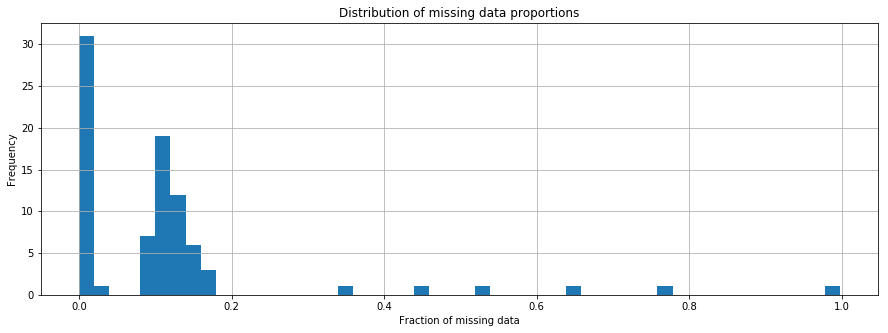

In [12]:
# Perform an assessment of how much missing data there is in each column of the dataset.
perc_missing_values = azdias.isnull().sum() / len(azdias)
perc_missing_values.hist(bins = 50, figsize = (15,5));
plt.xlabel('Fraction of missing data')
plt.ylabel('Frequency')
plt.title('Distribution of missing data proportions');
# We can see the outliers whose missing data is higher than 20% and they might need to be dropped later

There are 24 features with no missing values!


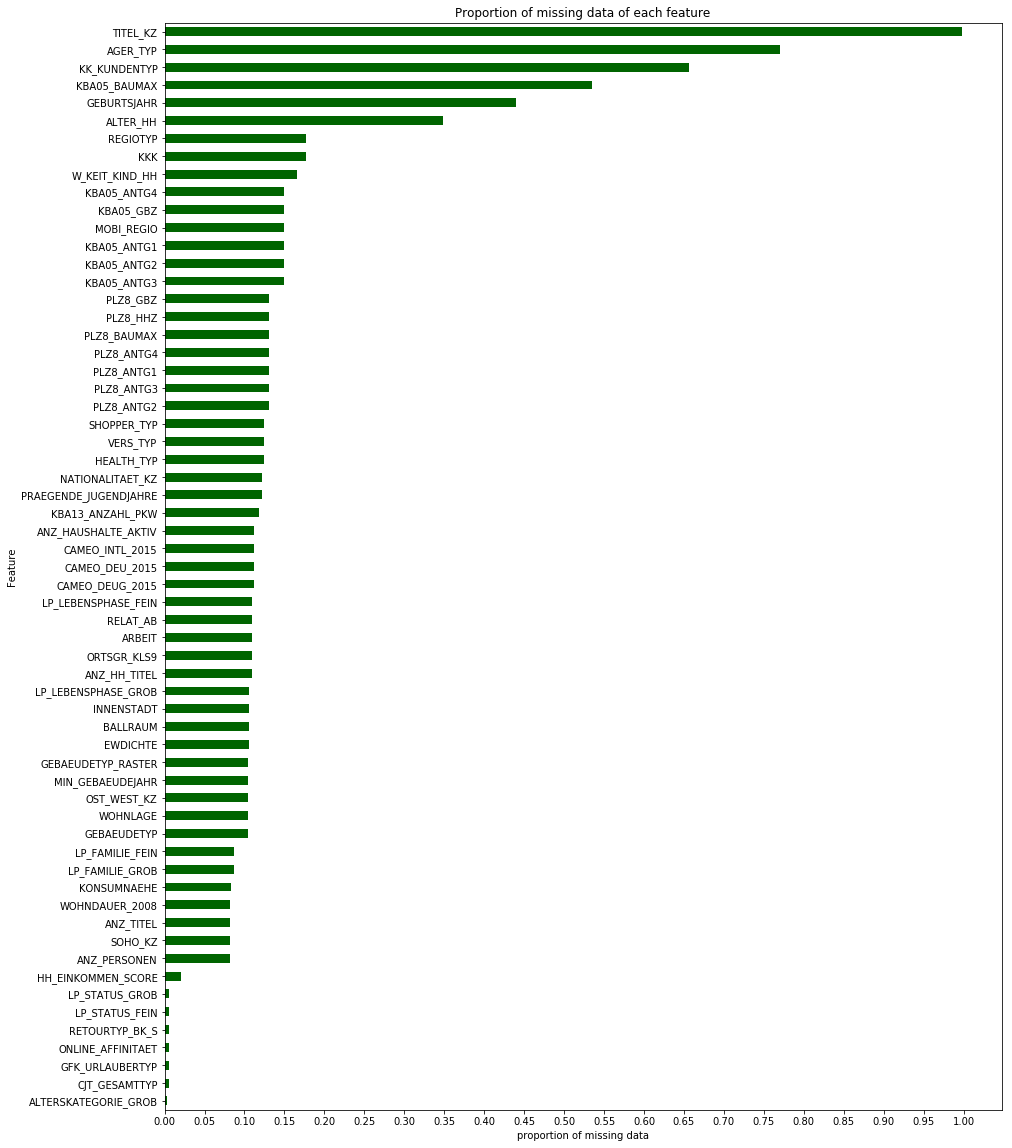

In [13]:
# Investigate patterns in the amount of missing data in each column.
# Identifying the proportion of each column of missing data
perc_missing_values[perc_missing_values > 0].sort_values().plot(kind='barh', figsize=(15,20), color = 'darkgreen')
# Making the x axis more representative of smaller values in terms of 0.05
plt.xticks(np.linspace(0,1,21))
plt.xlabel('proportion of missing data')
plt.ylabel('Feature')
plt.title('Proportion of missing data of each feature');
print('There are {} features with no missing values!'.format(len(perc_missing_values[perc_missing_values==0])))

In [14]:
# Remove the outlier columns from the dataset. (You'll perform other data engineering tasks such as re-encoding and imputation later.)
# We can visualize outliers with missing data higher than 0.20
# Getting the columns names to be dropped from the original dataset
outliers = perc_missing_values[perc_missing_values > 0.3].index
azdias = azdias.drop(outliers, axis = 1)
print('There are now {} features in the dataset after removing outleirs!'.format(azdias.shape[1]))

There are now 79 features in the dataset after removing outleirs!


#### Discussion 1.1.2: Assess Missing Data in Each Column

* It is clear that there were many missing values almost in all columns but 24 column, and the percentage of missing data varied widely. We can see from the graph that most data varied below 20% of missing data except for some features which we decided to drop considering them as outliers. Those features are 'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'.
* There was a feature that was completely missed 100% which is TITEL_KZ, so it needs further investigation to find out the reasons for such behavior.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [15]:
# How much data is missing in each row of the dataset?
# Calculating number of missing data in each row
row_missinng_data = azdias.isnull().sum(axis=1)
row_missinng_data.head()

0    43
1     0
2     0
3     7
4     0
dtype: int64

In [16]:
# Calculating proportion of missing data per row
perc_row_missing_data = row_missinng_data / azdias.shape[1]
perc_row_missing_data.head().round(2)

0    0.54
1    0.00
2    0.00
3    0.09
4    0.00
dtype: float64

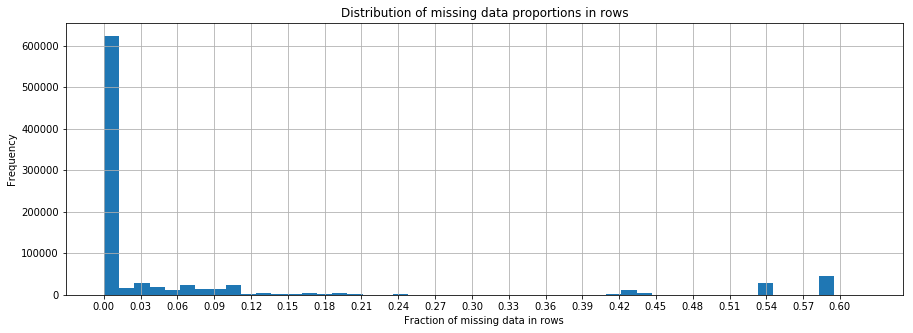

In [17]:
perc_row_missing_data.hist(bins = 50, figsize = (15,5));
plt.xticks(np.linspace(0,0.6,21))
plt.xlabel('Fraction of missing data in rows')
plt.ylabel('Frequency')
plt.title('Distribution of missing data proportions in rows');

In [18]:
# Write code to divide the data into two subsets based on the number of missing values in each row.
# We can select a threshold value of 0.1
rows_below_threshold = azdias[perc_row_missing_data < 0.3]
rows_above_threshold = azdias[perc_row_missing_data > 0.3]
print('{} of rows are below threshold while {} of rows are above threshold!'.format(round(len(rows_below_threshold) / len(azdias), 2), round(len(rows_above_threshold) / len(azdias), 2)))

0.9 of rows are below threshold while 0.1 of rows are above threshold!


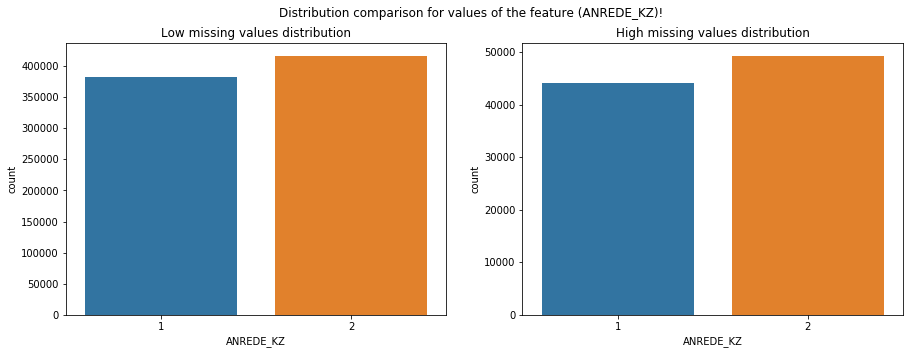

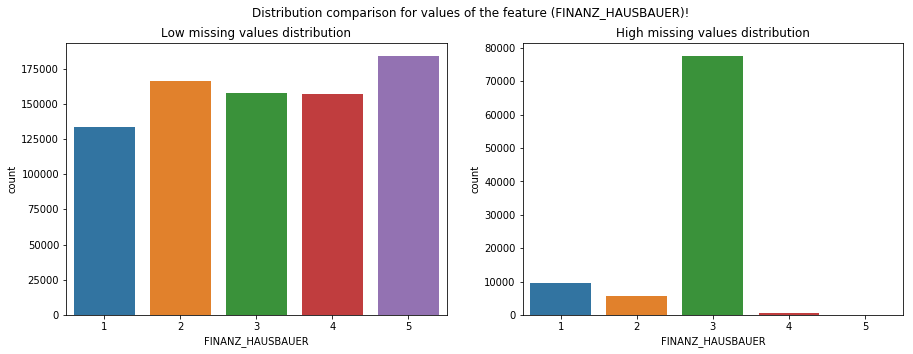

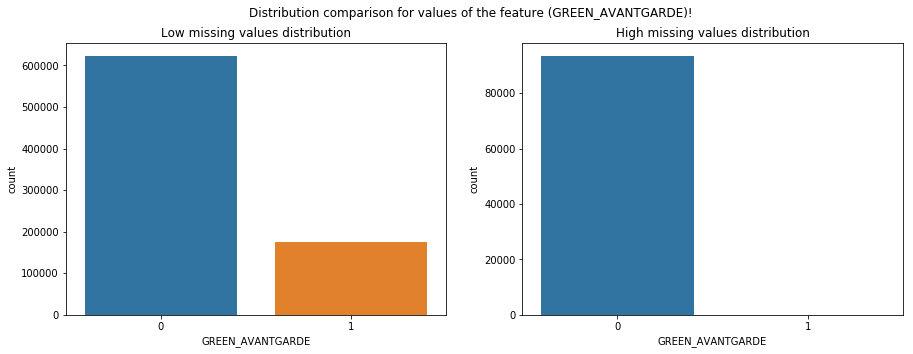

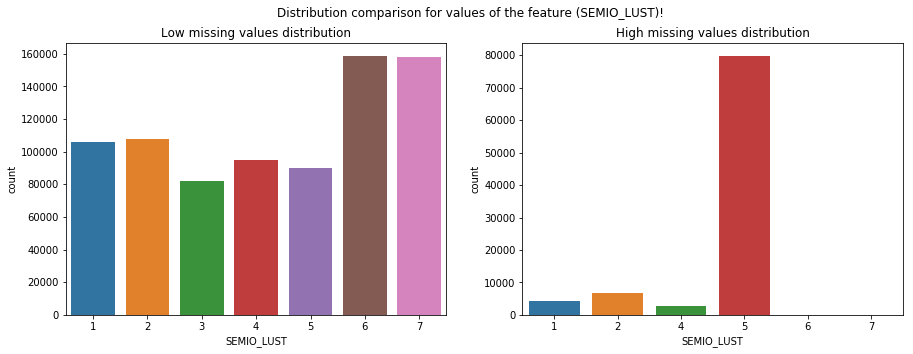

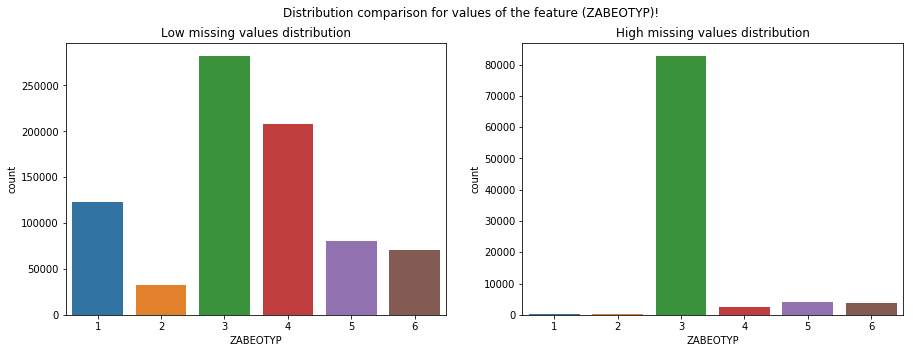

In [19]:
# Compare the distribution of values for at least five columns where there are no or few missing values, between the two subsets.
no_missing_columns = ['ANREDE_KZ', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE', 'SEMIO_LUST', 'ZABEOTYP']
# Creating afunction to avoid repeating the code
def plot_features(feature):
    plt.figure(figsize = (15,5))
    # using subplots for 2 plots together on same row
    ax1 = plt.subplot(1,2,1)
    sns.countplot(rows_below_threshold[feature])
    plt.title('Low missing values distribution')
    ax2 = plt.subplot(1,2,2)
    sns.countplot(rows_above_threshold[feature])
    plt.title('High missing values distribution')    
    plt.suptitle('Distribution comparison for values of the feature ({})!'.format(feature));
    
for feature in no_missing_columns:
    plot_features(feature)

In [20]:
# Working with only data of small missing values in rows
# dropping the original index of the dataset
azdias = rows_below_threshold.reset_index(drop = True)
print('There are now {} rows and {} features!'.format(azdias.shape[0], azdias.shape[1]))

There are now 797837 rows and 79 features!


#### Discussion 1.1.3: Assess Missing Data in Each Row

* with a reasonable threshold of 30% missing data, we can see that we are still maintaining a good shape of our dataset with 90% of rows are still with low missing values, so that we would still have very large number of observations.
* we can see that the distribution of values of each feature varies widely between both subsets, yet we can see that for features with 2 values only such as ANREDE_KZ while for GREEN_AVANTGRAGE we can see that there are no more values of 1 apparent on the dataset of high missing values. For multi values features, we can see that they are highly variant in both datasets. so that the decision is they are affecting our dataset, and we can not ignore them or assume the same behavior or drop them.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [21]:
# How many features are there of each data type?
data_types = feat_info['type'].value_counts()
data_types

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

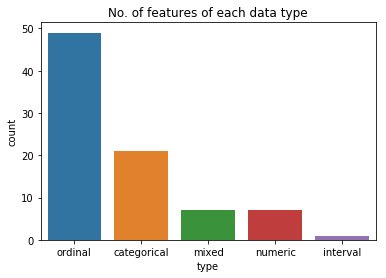

In [22]:
sns.countplot(feat_info['type'], order = data_types.index);
plt.title('No. of features of each data type');

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [23]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
# Categorical features as per feat info
categorical_features = feat_info[feat_info['type'] == 'categorical']['attribute']
# Since some of them are dropped from the azdias dataset
categorical_features_existing = [feat for feat in categorical_features if feat in azdias.columns]
# We can easily identify then binary and multi-level categories and which of them is numerical or objective
categorical_data = [[feat, azdias[feat].nunique(), azdias[feat].dtypes] for feat in azdias[categorical_features_existing].columns]
categorical_data = pd.DataFrame(categorical_data, columns = ['feature', 'variables', 'data_type'])
categorical_data.head()

,feature,variables,data_type
0,ANREDE_KZ,2,int64
1,CJT_GESAMTTYP,6,float64
2,FINANZTYP,6,int64
3,GFK_URLAUBERTYP,12,float64
4,GREEN_AVANTGARDE,2,int64


In [24]:
# Re-encode categorical variable(s) to be kept in the analysis.
# Identifying different types of data
## We will drop multi_level data
multi_level_num = categorical_data[(categorical_data['variables'] > 2) & (categorical_data['data_type'] != 'object')]['feature'].tolist()
multi_level_alph = categorical_data[(categorical_data['variables'] > 2) & (categorical_data['data_type'] == 'object')]['feature'].tolist()
# We will convert non numeric binary into binary
binary_non_numeric = categorical_data[(categorical_data['variables'] == 2) & (categorical_data['data_type'] == 'object')]['feature'].tolist()
# We will keep the following features as it is
binary_numeric = categorical_data[(categorical_data['variables'] == 2) & (categorical_data['data_type'] != 'object')]['feature'].tolist()

# Features to be dropped
dropped_categorical_features = multi_level_num + multi_level_alph

In [25]:
# Converting binary non numeric data to 0 and 1
uni_values = azdias[binary_non_numeric]['OST_WEST_KZ'].unique()
print('There are 2 unique letters in OST_WEST_KZ feature which are ({}, {})!'.format(uni_values[0], uni_values[1]))
# We would replace them wth 0 and 1
azdias['OST_WEST_KZ'].replace({'W':0, 'O':1}, inplace = True)
print('Replacment done successfully...')

There are 2 unique letters in OST_WEST_KZ feature which are (W, O)!
Replacment done successfully...


#### Discussion 1.2.1: Re-Encode Categorical Features

* The decision was to remove all multi-level data and to change the type of OST_WEST_KZ from letters into binary data, so that we can keep working with it.


> OneHotEncoder raises an error of "There are NaN values" so that i was not able to use it.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [26]:
# Identifying mixed features
mixed_features = feat_info[feat_info['type'] == 'mixed']['attribute']
mixed_features = [feat for feat in mixed_features if feat in azdias.columns]

In [27]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
# First variable
azdias['decade'] = azdias['PRAEGENDE_JUGENDJAHRE']
# units are in s
azdias['decade'] = azdias['decade'].replace({1:40, 2:40, 3:50, 4:50, 5:60, 6:60, 7:60, 8:70, 9:70, 10:80, 11:80, 12:80, 13:80, 14:90, 15:90})
# Second variable
azdias['mainstream_vs_avantgrade'] = azdias['PRAEGENDE_JUGENDJAHRE']
# Assumin Mainstream as zero, Avantgrade as one
azdias['mainstream_vs_avantgrade'] = azdias['mainstream_vs_avantgrade'].replace({1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0, 9:1, 10:0, 11:1, 12:0, 13:1, 14:0, 15:1})
# Dropping the original feature that is no longer used
azdias.drop('PRAEGENDE_JUGENDJAHRE', axis = 1, inplace = True)

In [28]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
# Converting the feature data to float
azdias['CAMEO_INTL_2015'] =azdias['CAMEO_INTL_2015'].astype(float)
# Tens is the tens digit number, while ones is for the single one digit
tens, ones = divmod(azdias['CAMEO_INTL_2015'], 10)
# First variable
# Assuming classes as [Wealthy Household:1, Prosperous Households:2, Comfortable Households:3, Less Affluent Households: 4, Poorer Households:5]
azdias['wealth'] = np.select([tens == 1, tens == 2, tens == 3, tens == 4, tens == 5], [1, 2, 3, 4 ,5])
# Assuming classes as [Pre-Family Couples & Singles:1, Young Couples With Children:2, Families With School Age Children:3,
# Older Families &  Mature Couples: 4, Elders In Retirement:5]
azdias['life_stage'] = np.select([ones == 1, ones == 2, ones == 3, ones == 4, ones == 5], [1, 2, 3, 4 ,5])
# Dropping the original feature that is no longer used
azdias.drop('CAMEO_INTL_2015', axis = 1, inplace = True)

# Features to drop
dropped_mixed_features = mixed_features.copy()
dropped_mixed_features.remove('PRAEGENDE_JUGENDJAHRE')
dropped_mixed_features.remove('CAMEO_INTL_2015')

#### Discussion 1.2.2: Engineer Mixed-Type Features

* I added features for new variables for the two feratures of PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015, while I would drop other features.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [29]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
features_to_drop = dropped_categorical_features + dropped_mixed_features
azdias.drop(features_to_drop, axis = 1, inplace = True)
print('The final structure of dataset is now {} rows and {} columns!'.format(azdias.shape[0], azdias.shape[1]))

The final structure of dataset is now 797837 rows and 64 columns!


In [30]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
azdias.dtypes.value_counts()

float64    39
int64      25
dtype: int64

In [31]:
# The final structure of the dataset
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,decade,mainstream_vs_avantgrade,wealth,life_stage
0,1.0,2,1,5,2,5,4,5,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,90.0,0.0,5,1
1,3.0,2,1,4,1,2,3,5,1,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,90.0,1.0,2,4
2,4.0,2,4,2,5,2,1,2,0,2.0,...,0.0,3.0,4.0,2.0,3.0,3.0,70.0,0.0,1,2
3,3.0,1,4,3,4,1,3,2,0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,70.0,0.0,4,3
4,1.0,2,3,1,5,2,2,5,0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,50.0,0.0,5,4


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [32]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    
    # convert missing value codes into NaNs, ...
    ''' Beginning of First Block of code '''
    
    # converting strings of each row to a list of elements
    codes = feat_info['missing_or_unknown'].apply(lambda x: [x.replace('[','').replace(']', '').strip().split(',')])
    # Converting this list to a dataframe, with columns equal to the max no. of elements here which is 3 elements
    missing_data = pd.DataFrame(codes.apply(lambda x: x[0]).tolist(), columns = ['code1', 'code2', 'code3']).fillna(np.nan)

    for col in missing_data.columns:
        # converting single values to numeric, and keeo string values as errors and then replace them with original values of strings
        missing_data[col] = pd.to_numeric(missing_data[col], errors = 'coerce').fillna(missing_data[col])
    # Concating both dataframes into a new one
    feat_info_missing = pd.concat([feat_info, missing_data], axis = 1)
    feat_info_missing.head()
    # filling original missing values with np.nan
    df = df.fillna(np.nan)
    # filling values that are represneted in 'missing or unknown' data as np.nan
    # Iterating thrrough columns and series of the dataset
    for col, data in df.iteritems():
        # Determining the codes that represent missing values for each column as in feat_info
        search_col = feat_info_missing[feat_info_missing['attribute'] == col]
        # The index of each row in feat_data
        idx = search_col.index[0]
        # Making a list of the codes that I would replace
        search_code = [search_col['code1'][idx],search_col['code2'][idx],search_col['code3'][idx]]
        # Replacing with np.nan
        data = data.replace(search_code,np.nan, inplace = True)    
    
    ''' End of First Block of code '''
    
    
    
    
    # remove selected columns and rows, ...
    ''' Beginning of Second Block of code '''
    # Calculating missing valeus percentage of columns
    perc_missing_values = df.isnull().sum() / len(df)
    # dropping outliers
    outliers = perc_missing_values[perc_missing_values > 0.3].index
    df = df.drop(outliers, axis = 1)
    # Repeating the same with rows
    row_missinng_data = df.isnull().sum(axis=1)
    perc_row_missing_data = row_missinng_data / df.shape[1]
    rows_below_threshold = df[perc_row_missing_data < 0.3]
    df = rows_below_threshold.reset_index(drop = True)

    ''' End of Second Block of code '''

    
    
    
    # select, re-encode, and engineer column values.
    ''' Beginning of Third Block of code '''
    # Categorical features as per feat info
    categorical_features = feat_info[feat_info['type'] == 'categorical']['attribute']
    # Since some of them are dropped from the df dataset
    categorical_features_existing = [feat for feat in categorical_features if feat in df.columns]
    # We can easily identify then binary and multi-level categories and which of them is numerical or objective
    categorical_data = [[feat, df[feat].nunique(), df[feat].dtypes] for feat in df[categorical_features_existing].columns]
    categorical_data = pd.DataFrame(categorical_data, columns = ['feature', 'variables', 'data_type'])
    # Identifying different types of data
    multi_level_num = categorical_data[(categorical_data['variables'] > 2) & (categorical_data['data_type'] != 'object')]['feature'].tolist()
    multi_level_alph = categorical_data[(categorical_data['variables'] > 2) & (categorical_data['data_type'] == 'object')]['feature'].tolist()
    binary_non_numeric = categorical_data[(categorical_data['variables'] == 2) & (categorical_data['data_type'] == 'object')]['feature'].tolist()
    binary_numeric = categorical_data[(categorical_data['variables'] == 2) & (categorical_data['data_type'] != 'object')]['feature'].tolist()
    # Features to be dropped
    dropped_categorical_features = multi_level_num + multi_level_alph  
    # Converting binary non numeric data to 0 and 1
    df['OST_WEST_KZ'].replace({'W':0, 'O':1}, inplace = True)

    # Identifying mixed features
    mixed_features = feat_info[feat_info['type'] == 'mixed']['attribute']
    mixed_features = [feat for feat in mixed_features if feat in df.columns]
    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    # First variable
    df['decade'] = df['PRAEGENDE_JUGENDJAHRE']
    # units are in s
    df['decade'] = df['decade'].replace({1:40, 2:40, 3:50, 4:50, 5:60, 6:60, 7:60, 8:70, 9:70, 10:80, 11:80, 12:80, 13:80, 14:90, 15:90})
    # Second variable
    df['mainstream_vs_avantgrade'] = df['PRAEGENDE_JUGENDJAHRE']
    # Assumin Mainstream as zero, Avantgrade as one
    df['mainstream_vs_avantgrade'] = df['mainstream_vs_avantgrade'].replace({1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0, 9:1, 10:0, 11:1, 12:0, 13:1, 14:0, 15:1})
    # Dropping the original feature that is no longer used
    df.drop('PRAEGENDE_JUGENDJAHRE', axis = 1, inplace = True)
    # Investigate "CAMEO_INTL_2015" and engineer two new variables.
    # Converting the feature data to float
    df['CAMEO_INTL_2015'] =df['CAMEO_INTL_2015'].astype(float)
    # Tens is the tens digit number, while ones is for the single one digit
    tens, ones = divmod(df['CAMEO_INTL_2015'], 10)
    # First variable
    # Assuming classes as [Wealthy Household:1, Prosperous Households:2, Comfortable Households:3, Less Affluent Households: 4, Poorer Households:5]
    df['wealth'] = np.select([tens == 1, tens == 2, tens == 3, tens == 4, tens == 5], [1, 2, 3, 4 ,5])
    # Assuming classes as [Pre-Family Couples & Singles:1, Young Couples With Children:2, Families With School Age Children:3,
    # Older Families &  Mature Couples: 4, Elders In Retirement:5]
    df['life_stage'] = np.select([ones == 1, ones == 2, ones == 3, ones == 4, ones == 5], [1, 2, 3, 4 ,5])
    # Dropping the original feature that is no longer used
    df.drop('CAMEO_INTL_2015', axis = 1, inplace = True)

    # Features to drop
    dropped_mixed_features = mixed_features.copy()
    dropped_mixed_features.remove('PRAEGENDE_JUGENDJAHRE')
    dropped_mixed_features.remove('CAMEO_INTL_2015')
    # If there are other re-engineering tasks you need to perform, make sure you
    # take care of them here. (Dealing with missing data will come in step 2.1.)
    features_to_drop = dropped_categorical_features + dropped_mixed_features
    df.drop(features_to_drop, axis = 1, inplace = True)

    ''' End of Second Block of code '''

# Return the cleaned dataframe.
    return(df)
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [33]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and do that now.
from sklearn.preprocessing import Imputer
# Using a strategy of imputing missing data as np.nan with the average values
imp_mean = Imputer(missing_values=np.nan, strategy='mean')
azdias_imputed = imp_mean.fit_transform(azdias)

In [34]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
# Scaling the data with mean of 0 and standard deviation of 1
azdias_imputed_scaled = ss.fit_transform(azdias_imputed)

In [35]:
# Converting the data I worked with to a dataframe
azdias_imputed_scaled = pd.DataFrame(azdias_imputed_scaled, columns = azdias.columns)
azdias_imputed_scaled.head()
# Making sure that there are no missing values at all  after imputation
if azdias_imputed_scaled.isnull().any().sum() == 0:
    print('There are no missing values!')
else:
    print('There are {} missing values! Review your model!'.format(azdias_imputed_scaled.isnull().any().sum()))

There are no missing values!


In [36]:
azdias_imputed_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,decade,mainstream_vs_avantgrade,wealth,life_stage
0,-1.766010,0.957932,-1.494575,1.537983,-1.040685,1.466063,0.958965,1.339139,-0.53045,1.085832,...,0.419855,1.445365,0.565032,-0.167371,-0.127756,0.684555,1.165642,-0.553133,1.185978,-1.234065
1,0.201243,0.957932,-1.494575,0.864621,-1.766949,-0.570955,0.244386,1.339139,1.88519,1.085832,...,-0.975784,0.403420,0.565032,-0.167371,-0.127756,-0.789357,1.165642,1.875277,-0.832598,0.765863
2,1.184869,0.957932,0.683195,-0.482102,1.138107,-0.570955,-1.184772,-0.791524,-0.53045,-0.269896,...,-0.975784,-0.638525,0.565032,-1.170966,-0.998317,-0.052401,-0.231979,-0.553133,-1.505457,-0.567422
3,0.201243,-1.043916,0.683195,0.191259,0.411843,-1.249961,0.244386,-0.791524,-0.53045,1.085832,...,0.419855,-0.638525,-0.347907,0.836224,0.307525,1.421511,-0.231979,-0.553133,0.513119,0.099221
4,-1.766010,0.957932,-0.042728,-1.155464,1.138107,-0.570955,-0.470193,1.339139,-0.53045,1.085832,...,0.419855,1.445365,1.477972,-1.170966,-0.998317,-0.052401,-1.629601,-0.553133,1.185978,0.765863


### Discussion 2.1: Apply Feature Scaling

* I first started with imputing all the missing data with the mean value, and then I performed standardscaling, so that I can use this data with Dimensionality reduction techniques

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [37]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
# I will not set any parameters
def do_pca(data, n_components = None):
    '''
    input: the dataframe to work on
           the no. of components to reduce df to (default is None)
    output: dataframe with dimensions reduced
                                                                   '''
    pca = PCA(n_components = n_components)
    # Fitting PCA to the datset imputed and scaled already
    df_pca = pca.fit_transform(data)
    # We return both variables since we will need both of them later
    return(pca, df_pca)

# Using the function I created
pca_function_azdias,  pca_azdias = do_pca(azdias_imputed_scaled)
# We can see that the resulted dataframe is of the same number of features but with variance of data of each column
pca_azdias_df = pd.DataFrame(pca_azdias, columns = azdias_imputed_scaled.columns)
pca_azdias_df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,decade,mainstream_vs_avantgrade,wealth,life_stage
0,3.907542,-2.619252,-2.883589,-0.491001,-2.495995,2.265187,0.922655,-0.697445,-1.116632,1.287836,...,0.202125,0.107575,-0.326722,0.098068,-0.344792,0.350098,-0.073464,0.174265,-0.106609,-0.002341
1,-0.925612,0.240004,-3.085667,2.266982,-0.841053,-0.155392,-0.982417,-0.521967,-1.348461,0.962135,...,-0.959821,0.576783,0.216031,0.459310,0.233834,0.767430,0.044638,-0.009428,0.087627,0.002982
2,-3.877621,1.319761,-0.755326,-0.755140,0.287250,0.187592,-0.245413,0.381640,0.125422,-0.999653,...,-0.600338,-0.359826,-0.042514,-0.400634,0.361944,-0.441416,-0.173789,0.115796,-0.664187,-0.012862
3,0.576072,0.243371,3.264535,0.560798,1.595783,-2.848021,1.972741,-1.253759,-0.874239,-0.595452,...,0.005647,0.224809,0.195699,-0.314936,-0.037176,-0.234584,-0.378242,0.441769,-0.415569,0.011533
4,-0.715393,-1.346589,-1.048593,-1.951729,-3.103468,-1.162988,-0.406866,3.320358,0.836056,1.017288,...,-0.279708,0.398192,0.005340,-0.298769,0.071687,-0.017667,0.200556,-0.065139,-0.339074,-0.014199


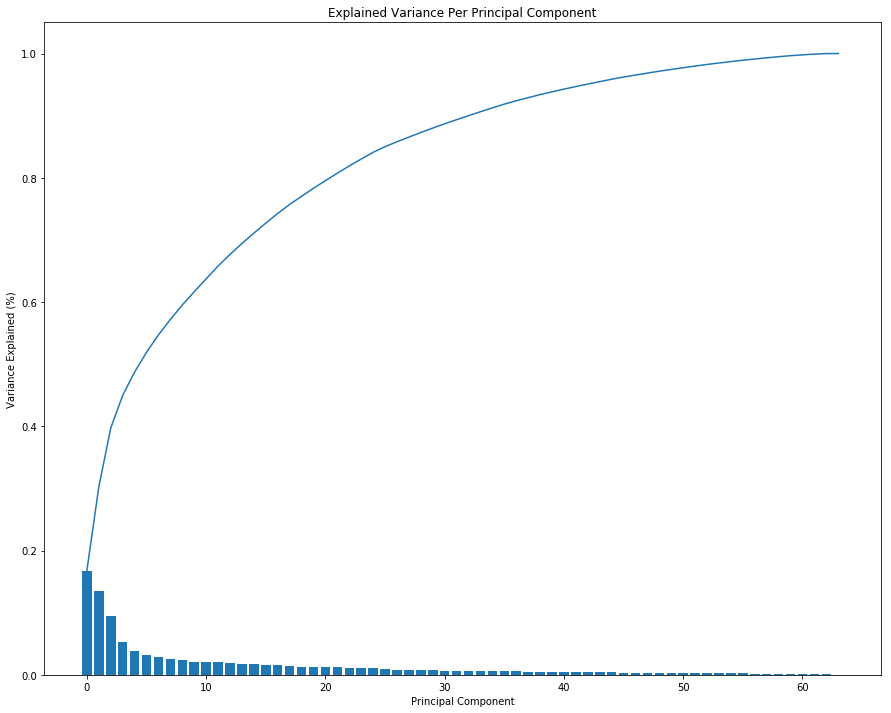

In [38]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    
    # The number of components to be used later for plotting
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    # Variance by each component
    vals = pca.explained_variance_ratio_
    
 
    plt.figure(figsize=(15, 12))
    ax = plt.subplot(111)
    # Returning the cumulative sum, so that we can plot it as a line
    cumvals = np.cumsum(vals)
    # plotting the variance of each component as a bar chart
    ax.bar(ind, vals)
    # On the same graph, we plot the cumulaitve sum of data
    ax.plot(ind, cumvals)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    

# Plotting the data I worked on
scree_plot(pca_function_azdias)

In [39]:
# Re-apply PCA to the data while selecting for number of components to retain.
# Based on the above chart, I would select number of components to be 15 since it almost accounts for 25% of the data
pca_function_azdias_reduced, pca_azdias_reduced = do_pca(azdias_imputed_scaled, 15)
pca_azdias_reduced_df = pd.DataFrame(pca_azdias_reduced)
pca_azdias_reduced_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,3.907543,-2.619233,-2.883536,-0.491212,-2.497111,2.262070,0.925184,-0.692636,-1.106702,1.302307,-0.008961,2.007374,-0.980913,-1.297237,-1.853432
1,-0.925608,0.239979,-3.085694,2.267082,-0.842272,-0.153452,-0.975843,-0.511677,-1.336352,0.976620,0.850589,-0.405596,-0.960341,1.990943,-0.472810
2,-3.877620,1.319758,-0.755342,-0.755184,0.287816,0.188351,-0.239678,0.391569,0.124781,-1.006656,-0.500891,-1.059483,0.244957,-0.685738,-0.181282
3,0.576071,0.243358,3.264532,0.560967,1.594987,-2.847544,1.966680,-1.255656,-0.862046,-0.582461,0.265549,1.881404,0.319408,1.428530,1.102731
4,-0.715390,-1.346597,-1.048605,-1.951452,-3.104348,-1.164573,-0.404208,3.318586,0.835251,0.999470,-1.274501,2.120461,0.290198,-0.798719,-0.836513


### Discussion 2.2: Perform Dimensionality Reduction

* I started doing pca transformation with the same number of features so that the total cumulative of variance would account for 100%. I can figure out that no. of features of 5 accounts for 55 % of data vaiation, 10 accounts for 60%, 15 accounts for 75%, 20 accounts for 80%, therefore I selected num_of_features of 15 since it accounts for reasonable variation and avoids overfitting of severe features.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [40]:
# Map weights for the first principal component to corresponding feature names and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the other cells.
def features_weight(pca, ith_component, pca_df):
    '''
        input: pca model
               the number of ith PCA to comapre weights
               the df which you will map the columns names to
                                                               '''
    # Getting the weight of all components and renaming columns
    feature_weight = pd.DataFrame(pca.components_, columns = pca_df.columns)
    # Getting the ith componenet compared
    weights_sorted = pd.DataFrame(feature_weight.iloc[ith_component,:].sort_values(ascending = False)).T

    return(weights_sorted)

In [41]:
# Map weights for the first principal component to corresponding feature names and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the other cells.
weights_1stPCA = features_weight(pca_function_azdias, 0, pca_azdias_df)
weights_1stPCA

,PLZ8_ANTG3,PLZ8_ANTG4,wealth,HH_EINKOMMEN_SCORE,ORTSGR_KLS9,EWDICHTE,FINANZ_HAUSBAUER,PLZ8_ANTG2,KBA05_ANTG4,ARBEIT,...,life_stage,BALLRAUM,INNENSTADT,PLZ8_GBZ,KONSUMNAEHE,KBA05_GBZ,FINANZ_MINIMALIST,KBA05_ANTG1,PLZ8_ANTG1,MOBI_REGIO
0,0.227859,0.221042,0.20569,0.20442,0.198671,0.196931,0.163573,0.155002,0.154006,0.144594,...,-0.121747,-0.128354,-0.165978,-0.168672,-0.168918,-0.218331,-0.218698,-0.226712,-0.227454,-0.243274


In [42]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weights_2ndPCA = features_weight(pca_function_azdias, 1, pca_azdias_df)
weights_2ndPCA

,ALTERSKATEGORIE_GROB,FINANZ_VORSORGER,SEMIO_ERL,SEMIO_LUST,RETOURTYP_BK_S,W_KEIT_KIND_HH,FINANZ_HAUSBAUER,SEMIO_KRIT,SEMIO_KAEM,ANREDE_KZ,...,SEMIO_RAT,SEMIO_FAM,FINANZ_ANLEGER,SEMIO_KULT,FINANZ_UNAUFFAELLIGER,SEMIO_PFLICHT,SEMIO_TRADV,FINANZ_SPARER,decade,SEMIO_REL
1,0.261193,0.234276,0.230997,0.184257,0.163776,0.119267,0.11545,0.114787,0.111334,0.089616,...,-0.171857,-0.184519,-0.205243,-0.219534,-0.228525,-0.228854,-0.23217,-0.237353,-0.252369,-0.255501


In [43]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weights_3rdPCA = features_weight(pca_function_azdias, 2, pca_azdias_df)
weights_3rdPCA

,SEMIO_VERT,SEMIO_SOZ,SEMIO_FAM,SEMIO_KULT,FINANZ_MINIMALIST,RETOURTYP_BK_S,FINANZ_VORSORGER,W_KEIT_KIND_HH,ALTERSKATEGORIE_GROB,SEMIO_REL,...,FINANZ_UNAUFFAELLIGER,FINANZ_SPARER,decade,SEMIO_ERL,FINANZ_ANLEGER,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,ANREDE_KZ
2,0.345228,0.262546,0.250201,0.23563,0.155793,0.108319,0.100888,0.090774,0.078631,0.069823,...,-0.099585,-0.106017,-0.107491,-0.176602,-0.188799,-0.217476,-0.276132,-0.314278,-0.337063,-0.36872


### Discussion 2.3: Interpret Principal Components

* we can interpret positive and negative values from each principal component of the describe ones, since opposite signs would account for inverisble porportional features and vice-versa.

* For 1st component, we can see that the most positive  dominant features are (PLZ8_ANTG3	PLZ8_ANTG4	wealth	HH_EINKOMMEN_SCORE	ORTSGR_KLS9	EWDICHTE	FINANZ_HAUSBAUER	PLZ8_ANTG2	KBA05_ANTG4	ARBEIT) respectively while the most negative affecting features include ( MOBI_REGIOl PLZ8_ANTG1  KBA05_ANTG1	FINANZ_MINIMALIST KBA05_GBZ KONSUMNAEHE PLZ8_GBZ INNENSTADT BALLRAUM life_stage). 

> We can go into further detail using the dictionary file and thus we can conclude a meaningful interpretation such that the main factors include the following features stronngly proportional and affecting it (No of family houses in plz8 region, wealth of money, Estimated household net income,  Financial typology) on the other hand,  we can see the following negatively affecting it(Number of family houses in the microcell, Distance to nearest urban center, Movement patterns, Number of buildings within the PLZ8 region).

* The same can be done for 2nd component where we can see that the most affecting features are (ALTERSKATEGORIE_GROB	FINANZ_VORSORGER	SEMIO_ERL	SEMIO_LUST	RETOURTYP_BK_S	W_KEIT_KIND_HH) positively and (FINANZ_UNAUFFAELLIGER	SEMIO_PFLICHT	SEMIO_TRADV	FINANZ_SPARER	decade	SEMIO_REL) negatively.

* For the third principle component, we can see that the most affecting positively are (SEMIO_VERT	SEMIO_SOZ	SEMIO_FAM	SEMIO_KULT	FINANZ_MINIMALIST	RETOURTYP_BK_S	FINANZ_VORSORGER	W_KEIT_KIND_HH) while negatively are (SEMIO_ERL	FINANZ_ANLEGER	SEMIO_RAT	SEMIO_KRIT	SEMIO_DOM	SEMIO_KAEM	ANREDE_KZ).

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [44]:
from sklearn.cluster import KMeans
# Over a number of different cluster counts...
# Using 10 different clusters due to the very long time it takes to model more clusters
ks = range(1,11,1)
score = []
for k in ks:
    # run k-means clustering on the data and...
    clf = KMeans(n_clusters = k).fit(pca_azdias_reduced_df)
    # compute the average within-cluster distances.
    score.append(np.abs(clf.score(pca_azdias_reduced_df)))

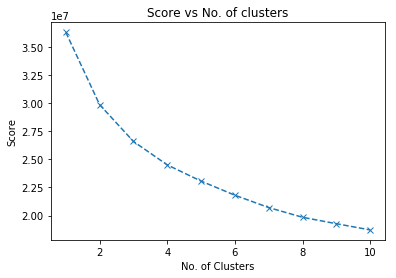

In [45]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
# Plotting the curve with clusters pointed as markers to easily visualize
plt.plot(ks, score, ls='--', marker = 'x')
plt.xlabel('No. of Clusters')
plt.ylabel('Score')
plt.title('Score vs No. of clusters');

In [46]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
# Fitting the model with the optimized parameters to the reduced dataset again
# Since the elbow is not very obvious here, so we take the less
k_optimized = 10
clf_optimized = KMeans(n_clusters = k_optimized).fit(pca_azdias_reduced_df)
# The segments or clusters or labels predicted by the classifier
segment_labels = clf_optimized.predict(pca_azdias_reduced_df)
segment_labels

array([8, 3, 0, ..., 2, 9, 4], dtype=int32)

### Discussion 3.1: Apply Clustering to General Population

* I have chosen 10 clusters since it achieves the lowest score of distance between points and the center. Also, the elbow shape is not very clear on this graph which suggests that it occur at higher number of clusters.
> No. of clusters was limited to 10 due to the very long time the local machie is taking to run the model with more clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [47]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter = ';')
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [48]:
# Apply preprocessing, feature transformation, and clustering from the general demographics onto the customer data, 
# obtaining cluster predictions for the customer demographics data.
print('There are {} rows and {} columns in the original dataset!'.format(customers.shape[0], customers.shape[1]))
# Using the defined function to clean data
customers = clean_data(customers)
print('Dataset cleaning is done successfully.............')
print('The final structure now has {} rows and {} columns!'.format(customers.shape[0], customers.shape[1]))

There are 191652 rows and 85 columns in the original dataset!
Dataset cleaning is done successfully.............
The final structure now has 141708 rows and 62 columns!


In [49]:
# Columns that are no more presented in Customer PCA due to the change in cut off percentage of outliers set to 0.3
main_list = np.setdiff1d(pca_azdias_df.columns.tolist(),customers.columns.tolist()).tolist()
# We would then add two new columns to represent those two features, so that PCA works properly, and all values would be
# of the same value of 0 to be the same weight
for feature in main_list:
    customers[feature] = 0
# Repeating the same steps used in the previous population dataset for imputing and scaling features
customers_imputed = imp_mean.fit_transform(customers)
customers_imputed_scaled = ss.fit_transform(customers_imputed)
print('There are now {} columns, and ready for PCA!'.format(customers.shape[1]))
customers_imputed_scaled = pd.DataFrame(customers_imputed_scaled, columns = customers.columns)

# Using transform and the original pca function
pca_customers_reduced = pca_function_azdias_reduced.transform(customers_imputed_scaled)
print('PCA applied successully')
pca_customers_reduced_df = pd.DataFrame(pca_customers_reduced)
# Using the optimized model to predict the labels
segment_labels_customers = clf_optimized.predict(pca_customers_reduced_df)
segment_labels_customers

There are now 64 columns, and ready for PCA!
PCA applied successully


array([4, 3, 4, ..., 7, 6, 5], dtype=int32)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

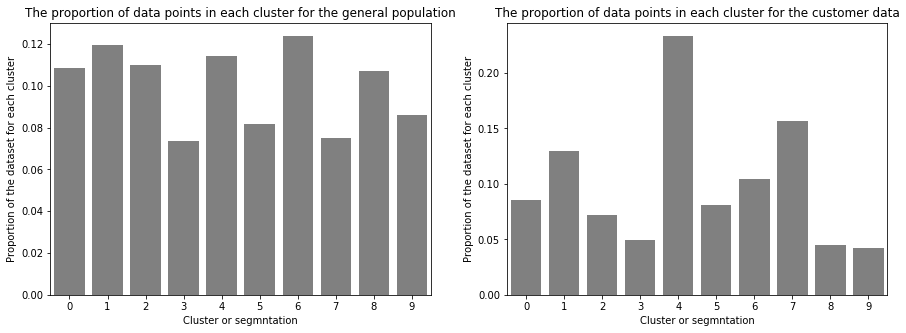

In [50]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# Calculating the proportion of each cluster to each dataset
population_proportion = pd.Series(segment_labels).value_counts(1)
customer_proportion = pd.Series(segment_labels_customers).value_counts(1)
plt.figure(figsize=(15,5))
# Plotting using seaborn
plt.subplot(121)
sns.barplot(x= population_proportion.index, y = population_proportion, color = 'grey')
plt.xlabel('Cluster or segmntation')
plt.ylabel('Proportion of the dataset for each cluster')
plt.title('The proportion of data points in each cluster for the general population')
plt.subplot(122)
sns.barplot(x= customer_proportion.index, y = customer_proportion, color = 'grey')
plt.xlabel('Cluster or segmntation')
plt.ylabel('Proportion of the dataset for each cluster')
plt.title('The proportion of data points in each cluster for the customer data');


In [51]:
# Definign a function for restoring data
def restore_df(pca_function, pca_data, labels, n_cluster, original_dataset):
    '''
    Inputs: PCA function used originally
            pca data already fitted
            labels predicted
            no. of cluster that is of interest
            original dataset that has the columns
                                                               '''
    # Inversing PCA transformation and getting data of cluster of interest only
    df = pca_function.inverse_transform(pca_data[labels == n_cluster])
    # Reversing scaling features
    df = ss.inverse_transform(df)
    df = pd.DataFrame(df, columns = original_dataset.columns)
    # rounding to 0 since original data were integers, and I used median here since data are not scaled and this could lead
    # to mistakenn interpretation by using average data
    df = pd.DataFrame(df.median().round(0)).T
    return(df)

def compare(customer_df, population_df):
    '''
        INPUTS customer dataframe of concerned cluster
               population dataframe of the same concerned cluseter
                                                                   '''
    # Concating both dataframes on rows to compare
    df = pd.concat([customer_df,population_df], axis=0, sort = False)
    # Setting index
    df.index =['customer_data','population_data']
    # Dropping duplicated columns so it would be easier to compare differences only
    for col in df.columns:
        if df.loc['customer_data', col] == df.loc['population_data', col]:
            df.drop(col, axis=1, inplace = True)
    return(df)

In [53]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
overpresented_feature = 4
# Using previoulsy defined function
customer_overpresented_4 = restore_df(pca_function_azdias_reduced, pca_customers_reduced, segment_labels_customers, overpresented_feature, customers)
population_lesspresented_4 = restore_df(pca_function_azdias_reduced, pca_azdias_reduced, segment_labels, overpresented_feature, azdias)
overpresented_comparison_4 = compare(customer_overpresented_4, population_lesspresented_4)
overpresented_comparison_4

,FINANZ_UNAUFFAELLIGER,SEMIO_FAM,SEMIO_MAT,SEMIO_VERT,SEMIO_ERL,SEMIO_PFLICHT,SEMIO_TRADV,VERS_TYP,W_KEIT_KIND_HH,ANZ_HAUSHALTE_AKTIV,...,PLZ8_HHZ,PLZ8_GBZ,ORTSGR_KLS9,RELAT_AB,decade,mainstream_vs_avantgrade,wealth,life_stage,KKK,REGIOTYP
customer_data,2.0,5.0,4.0,6.0,5.0,3.0,3.0,1.0,4.0,3.0,...,3.0,3.0,4.0,3.0,52.0,0.0,2.0,3.0,0.0,-0.0
population_data,1.0,4.0,3.0,7.0,4.0,2.0,2.0,2.0,5.0,-0.0,...,2.0,6.0,46.0,0.0,2.0,3.0,-0.0,0.0,4.0,3.0


In [55]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
underpresented_feature = 9
# Using previoulsy defined function
customer_underpresented_9 = restore_df(pca_function_azdias_reduced, pca_customers_reduced, segment_labels_customers, underpresented_feature, customers)
population_morepresented_9 = restore_df(pca_function_azdias_reduced, pca_azdias_reduced, segment_labels, overpresented_feature, azdias)
underpresented_comparison_9 = compare(customer_underpresented_9, population_morepresented_9)
underpresented_comparison_9

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,SEMIO_SOZ,SEMIO_FAM,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,decade,mainstream_vs_avantgrade,wealth,life_stage,KKK,REGIOTYP
customer_data,3.0,3.0,2.0,4.0,2.0,3.0,3.0,3.0,6.0,5.0,...,4.0,4.0,6.0,3.0,67.0,0.0,4.0,3.0,0.0,0.0
population_data,4.0,5.0,1.0,5.0,1.0,1.0,2.0,2.0,5.0,4.0,...,6.0,2.0,46.0,0.0,2.0,3.0,-0.0,0.0,4.0,3.0


### Discussion 3.3: Compare Customer Data to Demographics Data

Analysis:

For the underpresnted cluster no. 9 compared to the population, we can see that almost all features are relatively different from each other up to 51 feature, for example the finanical state of customer data is average, while thos who follow the same cluster in population are of very low income. Also, it is obvvious that the size of community, Health typology, income for young people are also reasons that affect it.

In summary, we can see that segmentation of population is realtively popular with the mail-order company, they both almost follow the same trend of highest and lowest proportions although the proportion is different such that cluster 4 in customer data is very superior to other culsters and reaches up to 30% of all the data, on the other hand the clusters in population is relatively close and this could be explained due to normal distributions of the population so that we can see that cluster 4 is still the superior class yet its contribution is 0.16 only 0.04 higher than the next cluster.

We can colculde that the mail-company should pay more attention for cluster no. 4 becuase they are more likely to be targets for the company based on their other activity, and it should kind of ignore cluster 9 because it would not be efficient for the company.


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.